In [18]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# This file comprises our dataset. It contains features derived from the original audio using librosa.
df = pd.read_csv('fma_metadata/features.csv', header=[0, 1, 2], skiprows=0, index_col=0)

# This file contains additional data related to mussical properties, popularity, etc. We may not need it.
# The biggest limitation is that is only contains information for about a tenth of the tracks.
echo_nest = pd.read_csv('fma_metadata/echonest.csv', header=[0, 1, 2], skiprows=0, index_col=0)

# This file contains a bunch of metadata including, notably, genre information.
tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0, 1], skiprows=0, index_col=0)

# This file contains the hierarchy of genres, and it maps genre IDs to names. It does not contain data points.
genres = pd.read_csv('fma_metadata/genres.csv', index_col=0)

print("Dataset:")
print(df.head())

print("\nShape of dataset:", df.shape)
print("Shape of Echo Nest data:", echo_nest.shape)
print("Shape of track data:", tracks.shape)
print("Shape of genres:", genres.shape)

Dataset:
feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...              

In [2]:
# Remove duplicate instances from the dataset

print("Number of duplicate instances in the dataset:")
print(df.duplicated().sum())

df = df.drop_duplicates()

print("\nShape of dataset without duplicates:")
print(df.shape)

Number of duplicate instances in the dataset:
2111

Shape of dataset without duplicates:
(104463, 518)


In [3]:
# Merge the target feature from tracks with the librosa data.
# I'm not sure if this step is entirely necessary.

# Convert the values in the "genres_all" column into lists.
tracks['track', 'genres_all'] = tracks['track', 'genres_all'].map(ast.literal_eval)

# Add an extra level to tracks to merge with the librosa data.
tracks.columns = pd.MultiIndex.from_tuples([(a, b, '') for a, b in tracks.columns])

# Merge the "genres_all" column with librosa data.
df = pd.merge(df, tracks['track', 'genres_all', ''], on=('track_id'))

print("Shape of dataset with a column for the target feature:")
print(df.shape)

Shape of dataset with a column for the target feature:
(104463, 519)


In [4]:
# Check if there are any missing values in the descriptive features

print("Number of instances with a missing value in the descriptive features:")
print(sum(df.isnull().sum()))

Number of instances with a missing value in the descriptive features:
0


In [5]:
# Remove instances with no infomation for the target feature.

print("Number of instances with an empty target feature:")
print(sum(df[('track', 'genres_all', '')].str.len() == 0))

df = df[df[('track', 'genres_all', '')].str.len() > 0]

print("\nShape of dataset without instances with an empty target value:")
print(df.shape)

Number of instances with an empty target feature:
2128

Shape of dataset without instances with an empty target value:
(102335, 519)


In [6]:
# Here is a possible feature selection based on domain knowledge.

chroma_cens_mean = df.loc[:, [('chroma_cens', 'mean', f'{i:02d}') for i in range(1, 13)]]
mfcc_mean = df.loc[:, [('mfcc', 'mean', f'{i:02d}') for i in range(1, 21)]]
spectral_contrast_mean = df.loc[:, [('spectral_contrast', 'mean', f'{i:02d}') for i in range(1, 8)]]
spectral_centroid_mean = df.loc[:, [('spectral_centroid', 'mean', '01')]]

df_selected = pd.concat([chroma_cens_mean, mfcc_mean, spectral_contrast_mean, spectral_centroid_mean], axis=1)
print(df_selected.head())

feature    chroma_cens                                                    \
statistics        mean                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             0.474300  0.369816  0.236119  0.228068  0.222830  0.221415   
3             0.232784  0.229469  0.225674  0.216713  0.220512  0.242744   
5             0.258420  0.303385  0.250737  0.218562  0.245743  0.236018   
10            0.229882  0.286978  0.240096  0.226792  0.192443  0.288410   
20            0.202806  0.245125  0.262997  0.187961  0.182397  0.238173   

feature                                             ...      mfcc            \
statistics                                          ...      mean             
number            07        08        09        10  ...        19        20   
track_id                                            ...                       

In [7]:
# Some possible ways to explore the dataset.

print("Info:")
print(df_selected.info())

print("\nDescription:")
print(df_selected.describe())

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 102335 entries, 2 to 155320
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   (chroma_cens, mean, 01)        102335 non-null  float64
 1   (chroma_cens, mean, 02)        102335 non-null  float64
 2   (chroma_cens, mean, 03)        102335 non-null  float64
 3   (chroma_cens, mean, 04)        102335 non-null  float64
 4   (chroma_cens, mean, 05)        102335 non-null  float64
 5   (chroma_cens, mean, 06)        102335 non-null  float64
 6   (chroma_cens, mean, 07)        102335 non-null  float64
 7   (chroma_cens, mean, 08)        102335 non-null  float64
 8   (chroma_cens, mean, 09)        102335 non-null  float64
 9   (chroma_cens, mean, 10)        102335 non-null  float64
 10  (chroma_cens, mean, 11)        102335 non-null  float64
 11  (chroma_cens, mean, 12)        102335 non-null  float64
 12  (mfcc, mean, 01)        

<Axes: xlabel='feature-statistics-number', ylabel='feature-statistics-number'>

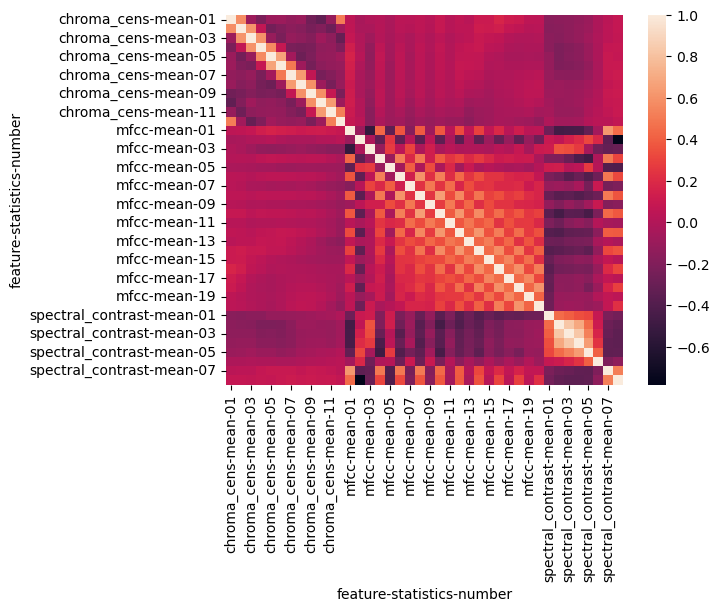

In [8]:
# Create a correlation matrix using the selected features.

sns.heatmap(df_selected.corr(), annot=False)

<Axes: xlabel='feature-statistics-number', ylabel='feature-statistics-number'>

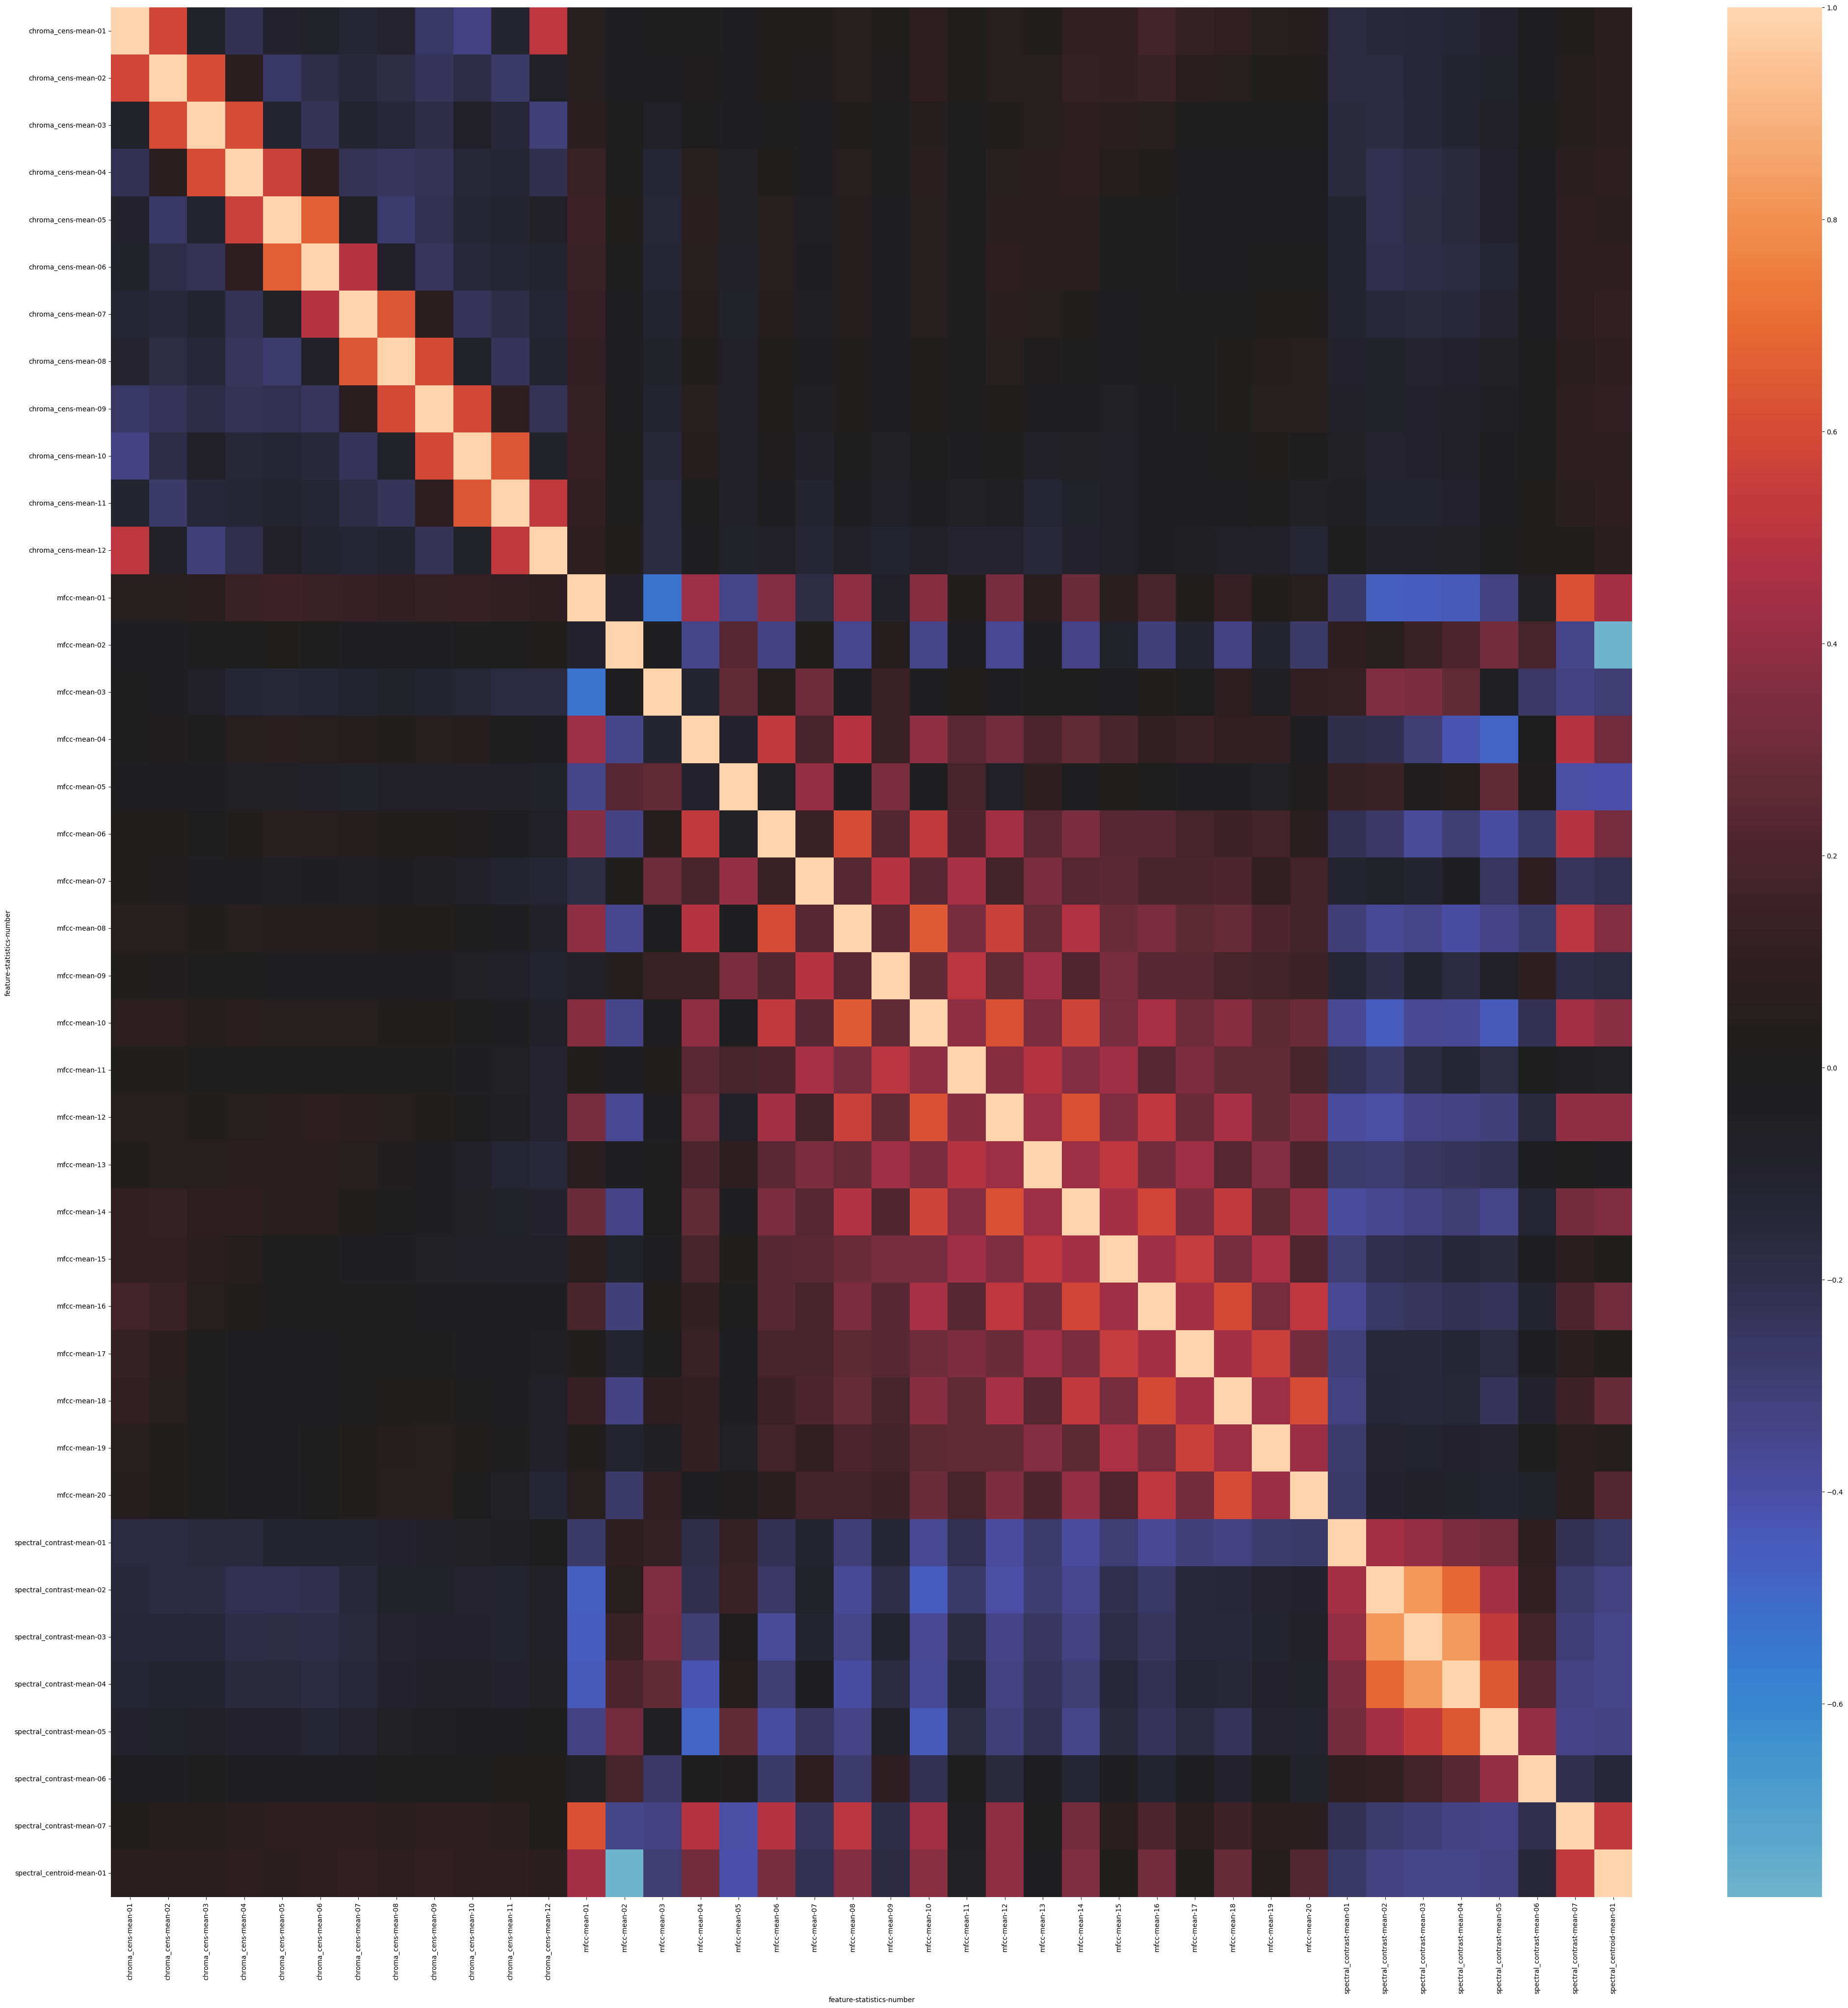

In [9]:
# Alternate correlation matrix using the selected features.

plt.figure(figsize=(50,50))
sns.heatmap(df_selected.corr(), annot=False, center=0)

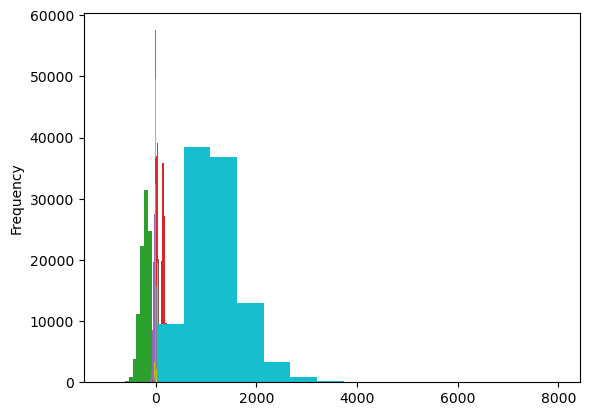

In [10]:
# Fix this

for (name, series) in df_selected.items():
    ax = df[name].plot.hist(bins=15)
    fig = ax.figure

In [11]:
# Use kNN on the predefined "small" subset (a balanced subset of 8000 tracks with 8 genres).

# Get the indexes of the instances in the subsets.
small = tracks['set', 'subset'] == 'small'
val = tracks['set', 'split'] == 'validation'
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'

train_indexes = df_selected.index.intersection(tracks[small & train].index)
val_indexes = df_selected.index.intersection(tracks[small & val].index)
test_indexes = df_selected.index.intersection(tracks[small & test].index)

# Select and standardize the features (kNN is sensitive to their scales).
X_train = df_selected.loc[train_indexes]
X_val = df_selected.loc[val_indexes]
X_test = df_selected.loc[test_indexes]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Select the target levels and encode them (since genre is categorical).
y_train = tracks.loc[train_indexes, ('track', 'genre_top')]
y_val = tracks.loc[val_indexes, ('track', 'genre_top')]
y_test = tracks.loc[test_indexes, ('track', 'genre_top')]

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

# Fine-tune the value for K using the validation set.
best_score = 0
best_k = 1
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_encoded)
    score = knn.score(X_val_scaled, y_val_encoded)
    
    if score > best_score:
        best_score = score
        best_k = k

print("Best value for K:", best_k)

# Make predictions using the test set.
y_test_predicted = knn.predict(X_test_scaled)
accuracy_score = accuracy_score(y_test_encoded, y_test_predicted)
print("Test set accuracy: {:.2%}".format(accuracy_score))

# We may also want to show a table of F1 scores or another performance measure.

Best value for K: 22
Test set accuracy: 36.86%


Text(120.72222222222221, 0.5, 'Actual')

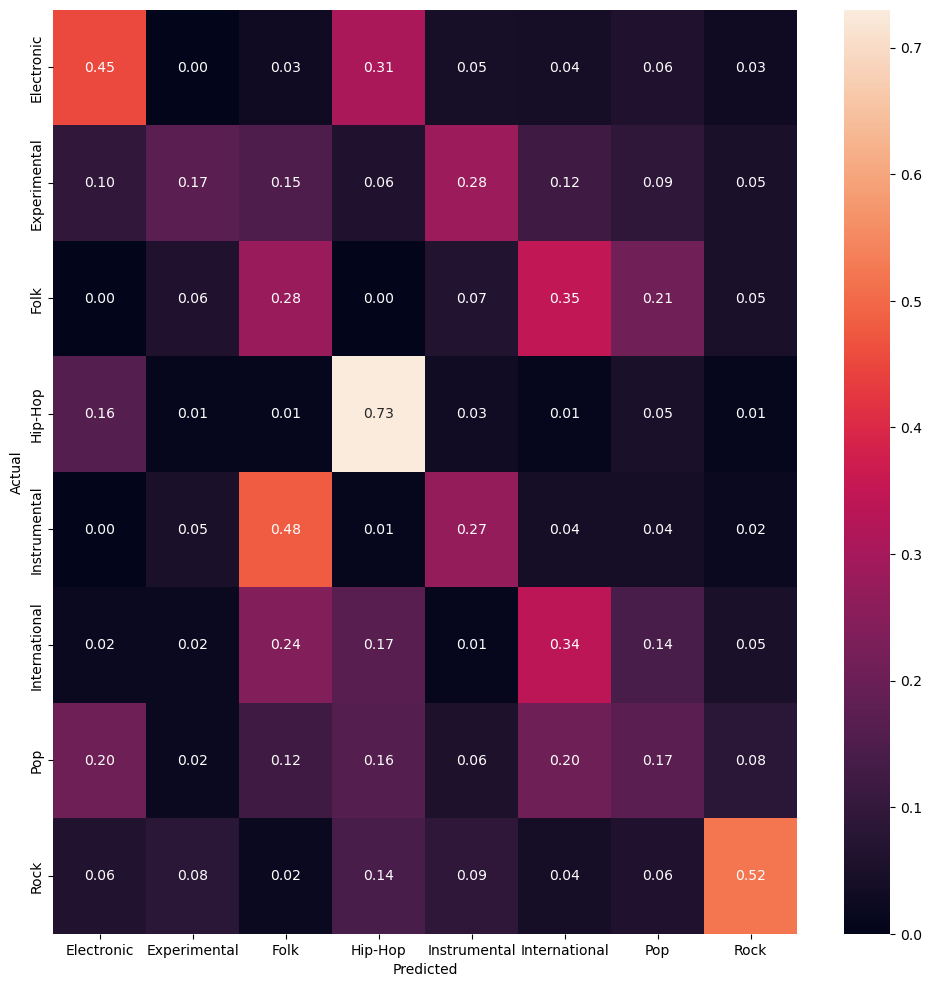

In [14]:
# Create a confusion matrix for the descriptive features.

matrix = confusion_matrix(y_test_encoded, y_test_predicted)
matrix = matrix / matrix.sum(axis=1)

plt.figure(figsize=(12, 12))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(0.5, 1.0, 'F1 Scores per genre')

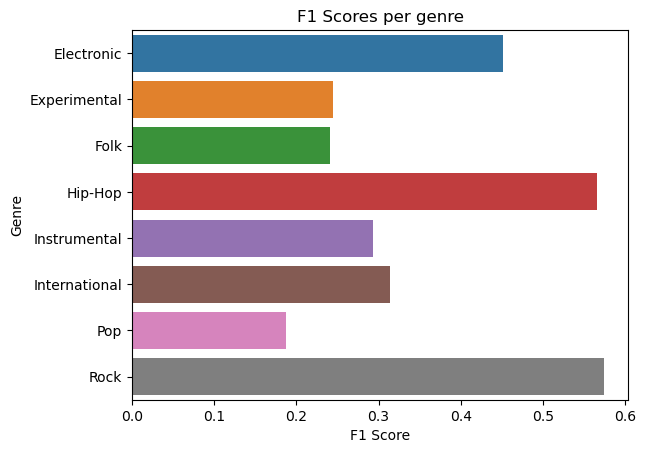

In [17]:
# Create a bar chart showing F1 scores.

f1_scores = f1_score(y_test_encoded, y_test_predicted, average=None)

sns.barplot(x=f1_scores, y=encoder.classes_)
plt.xlabel('F1 Score')
plt.ylabel('Genre')
plt.title('F1 Scores per genre')